Google Drive link- https://drive.google.com/drive/folders/1PZM1l2FbDBGGJxmRZjVPpGTefv5_DJjO?usp=sharing

#Import necessary libraries:




In [75]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import seaborn as sns
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
sns.set()

**Importing Dataset**

In [76]:

from google.colab import files
uploaded = files.upload()


Saving flipkart_data.csv to flipkart_data.csv


In [77]:
movie_reviews = pd.read_csv('/content/flipkart_data1.csv')


In [78]:
movie_reviews.shape

(9976, 2)

In [79]:
movie_reviews.head(5)

,review,rating
0,It was nice produt. I like it's design a lot. ...,5
1,awesome sound....very pretty to see this nd th...,5
2,awesome sound quality. pros 7-8 hrs of battery...,4
3,I think it is such a good product not only as ...,5
4,awesome bass sound quality very good bettary l...,5


Adding a new column of **sentiment** which categorizes review as **positive** if it is rated above 3 or else **negative**.

In [80]:
movie_reviews['sentiment'] = movie_reviews['rating'].apply(lambda x: 'positive' if x > 3 else 'negative')

Checking for null values.

In [81]:
movie_reviews.isnull().values.any()

False

In [82]:
movie_reviews.head(5)

,review,rating,sentiment
0,It was nice produt. I like it's design a lot. ...,5,positive
1,awesome sound....very pretty to see this nd th...,5,positive
2,awesome sound quality. pros 7-8 hrs of battery...,4,positive
3,I think it is such a good product not only as ...,5,positive
4,awesome bass sound quality very good bettary l...,5,positive


<Axes: xlabel='sentiment', ylabel='count'>

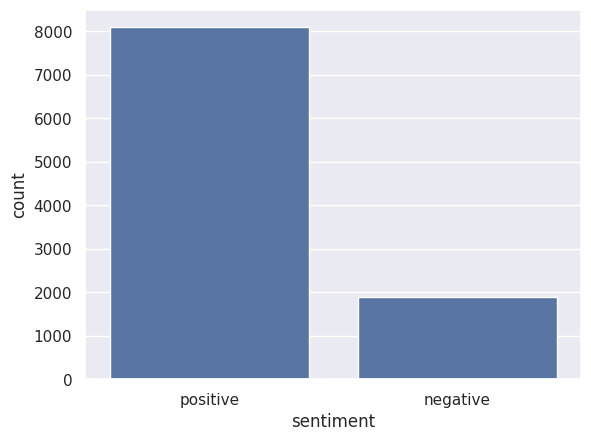

In [83]:
sns.countplot(x='sentiment', data=movie_reviews)

In [84]:
movie_reviews.sentiment.value_counts()

positive    8091
negative    1885
Name: sentiment, dtype: int64

# Data Cleaning:

In below cell we can see that the review written by the costumer contains many unnecessary characters (i.e. braces, white spaces, numbers and tags)

In [85]:
movie_reviews["review"][2]

'awesome sound quality. pros 7-8 hrs of battery life (including 45 mins approx call time)Awesome sound output. Bass and treble are really very clear without equaliser. With equaliser, sound wary depends on the handset sound quality.Weightless to carry and in head tooMic is good, but in traffic it is not too good (3.25/5)3.5mm Option is really important to mention. Really expecting other leading brands to implement this.ConsVery tight in ears. adjusters are ok .. this ll be very tight...READ MORE'

Removing anything between opening and closing <> like HTML tags.


In [86]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

Stopwords is a list of words which are considered to have no significance in determining the meaning of a document and are often just noise.

In [87]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [88]:
def preprocess_text(sen):

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

Listing each and every review from dataset movie_reviews in X after passing it to the function preprocess_text.

In [89]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [90]:
# Sample cleaned up movie review
X[2]


'awesome sound quality pros hrs battery life including mins approx call time awesome sound output bass treble really clear without equaliser equaliser sound wary depends handset sound quality weightless carry head toomic good traffic good mm option really important mention really expecting leading brands implement consvery tight ears adjusters ok tight read '

In [91]:
# Converting sentiment labels to 0 & 1
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [92]:
# The train set will be used to train our learning models
# while test set will be used to evaluate how well our model performs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# **Preparing embedding layer**

Embedding layer converts our textual data into numeric form. It is then used as the first layer for the deep learning models in Keras.

This prepares text data for input into a neural network model by converting it into a format that can be easily processed and understood by the model.

In [93]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [94]:
# calculating the vocabulary length by taking the count of unique words in the tokenizer's word index and adding 1
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

5842

Reviews in dataset often comes in variable-length sequences. However, neural network models typically expect inputs of fixed size.

In [95]:
#Limitting input data size to 100 and padding
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [96]:
 #Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
glove_file = open('glove_file_embedding.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [97]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [98]:
embedding_matrix.shape

(5842, 100)

In [99]:
from keras.layers import LSTM

In [100]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(units=62, dropout=0.2, recurrent_dropout=0.2))

lstm_model.add(Dense(1, activation='sigmoid'))

In [101]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          584200    
                                                                 
 lstm_2 (LSTM)               (None, 62)                40424     
                                                                 
 dense_2 (Dense)             (None, 1)                 63        
                                                                 
Total params: 624687 (2.38 MB)
Trainable params: 40487 (158.15 KB)
Non-trainable params: 584200 (2.23 MB)
_________________________________________________________________
None


In [102]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
50/50 [==============================] - 16s 263ms/step - loss: 0.5412 - acc: 0.7993 - val_loss: 0.4999 - val_acc: 0.8001
Epoch 2/6
50/50 [==============================] - 13s 255ms/step - loss: 0.4876 - acc: 0.8105 - val_loss: 0.4988 - val_acc: 0.8001
Epoch 3/6
50/50 [==============================] - 13s 255ms/step - loss: 0.4857 - acc: 0.8105 - val_loss: 0.4975 - val_acc: 0.8001
Epoch 4/6
50/50 [==============================] - 13s 255ms/step - loss: 0.4508 - acc: 0.8158 - val_loss: 0.3905 - val_acc: 0.8477
Epoch 5/6
50/50 [==============================] - 13s 255ms/step - loss: 0.3918 - acc: 0.8307 - val_loss: 0.3836 - val_acc: 0.8578
Epoch 6/6
50/50 [==============================] - 13s 254ms/step - loss: 0.3787 - acc: 0.8452 - val_loss: 0.3768 - val_acc: 0.8484


In [103]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

63/63 [==============================] - 1s 21ms/step - loss: 0.3714 - acc: 0.8457


In [104]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.37141892313957214
Test Accuracy: 0.8456913828849792


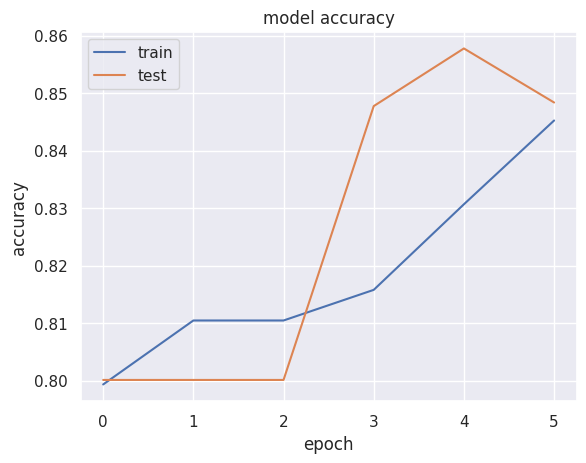

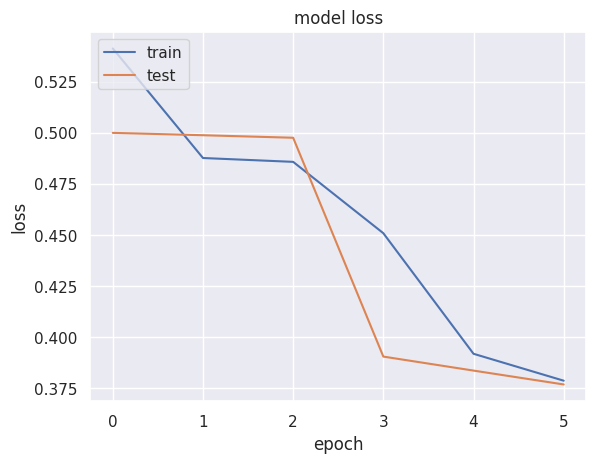

In [105]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [109]:
lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

In [106]:
validation_sen=['Worst product ever']
validation_sen_tokened= word_tokenizer.texts_to_sequences(validation_sen)
validation_sen_padded= pad_sequences(validation_sen_tokened, maxlen=100, truncating='post', padding='post')
print(validation_sen[0])
print("Probability of positive: {}",format(lstm_model.predict(validation_sen_padded)[0]))
if(lstm_model.predict(validation_sen_padded)[0]>0.4):
    print("Positive Review")
else:
  print("Negative Review")

Worst product ever
1/1 [==============================] - 0s 433ms/step
Probability of positive: {} [0.30747518]
1/1 [==============================] - 0s 46ms/step
Negative Review


In [107]:
validation_sen=['Good Packaging']
validation_sen_tokened= word_tokenizer.texts_to_sequences(validation_sen)
validation_sen_padded= pad_sequences(validation_sen_tokened, maxlen=100, truncating='post', padding='post')
print(validation_sen[0])
print("Probability of positive: {}",format(lstm_model.predict(validation_sen_padded)[0]))
if(lstm_model.predict(validation_sen_padded)[0]>0.4):
    print("Positive Review")
else:
  print("Negative Review")

Good Packaging
1/1 [==============================] - 0s 32ms/step
Probability of positive: {} [0.9394699]
1/1 [==============================] - 0s 30ms/step
Positive Review


63/63 [==============================] - 1s 21ms/step
Confusion Matrix:
[[ 220  136]
 [ 172 1468]]


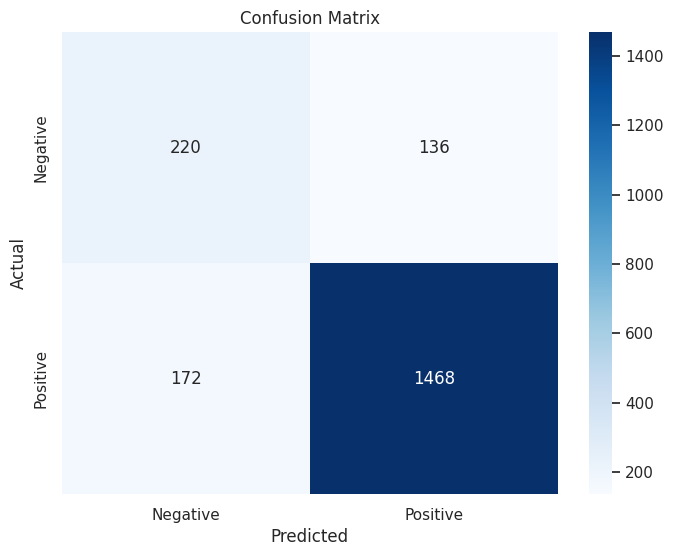

In [108]:
from sklearn.metrics import confusion_matrix
# Generate predictions on the test set
y_prob = lstm_model.predict(X_test)

# Convert probabilities to predicted classes (0 or 1)
y_pred = (y_prob > 0.5).astype(int)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
